# Load Data

In [0]:
import glob
import math
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import random
import sklearn.metrics as metrics

from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import add, concatenate, Conv2D, Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Activation, AveragePooling2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [20]:


trDatOrg       = np.load('./drive/My Drive/Flower_Power/flrnonflr-train-imgs224-0.8.npz')['arr_0']
trLblOrg       = np.load('./drive/My Drive/Flower_Power/flrnonflr-train-labels224-0.8.npz')['arr_0']
tsDatOrg       = np.load('./drive/My Drive/Flower_Power/flrnonflr-test-imgs224-0.8.npz')['arr_0']
tsLblOrg       = np.load('./drive/My Drive/Flower_Power/flrnonflr-test-labels224-0.8.npz')['arr_0']

print("For the training and test datasets:")
print("The shapes are %s, %s, %s, %s" \
      %(trDatOrg.shape, trLblOrg.shape, tsDatOrg.shape, tsLblOrg.shape))

For the training and test datasets:
The shapes are (3835, 224, 224, 3), (3835,), (959, 224, 224, 3), (959,)


Showing 76 index image, It is 1.0


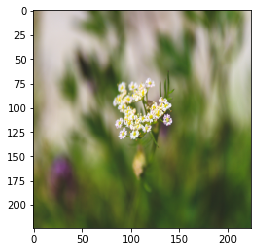

Showing 18 index image, It is 1.0


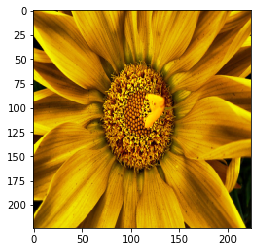

Showing 483 index image, It is 1.0


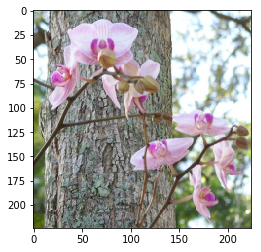

Showing 293 index image, It is 1.0


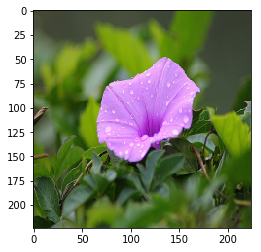

Showing 328 index image, It is 1.0


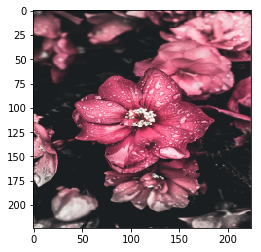

Showing 354 index image, It is 1.0


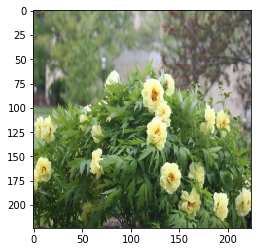

Showing 341 index image, It is 1.0


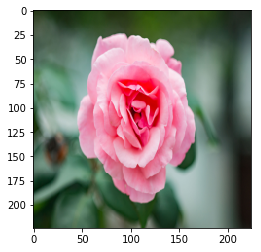

Showing 946 index image, It is 0.0


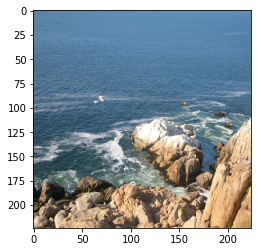

Showing 854 index image, It is 0.0


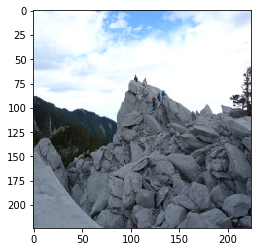

Showing 800 index image, It is 0.0


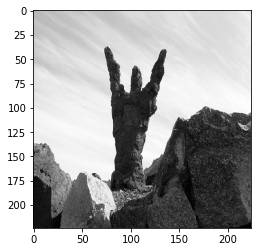

Showing 801 index image, It is 0.0


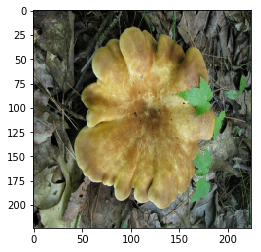

Showing 922 index image, It is 0.0


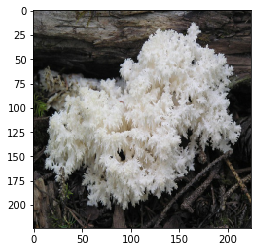

Showing 722 index image, It is 0.0


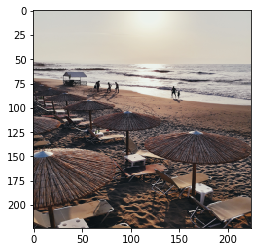

Showing 299 index image, It is 1.0


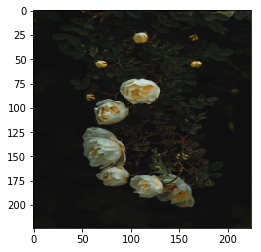

Showing 468 index image, It is 1.0


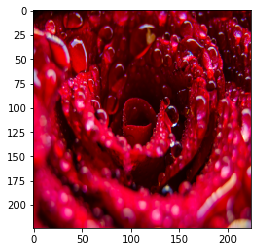

Showing 857 index image, It is 0.0


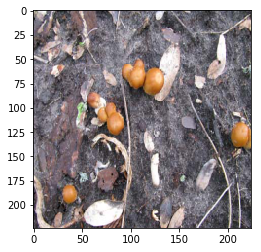

Showing 865 index image, It is 0.0


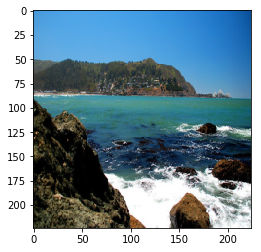

Showing 676 index image, It is 0.0


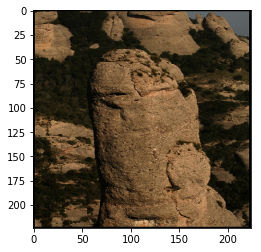

Showing 293 index image, It is 1.0


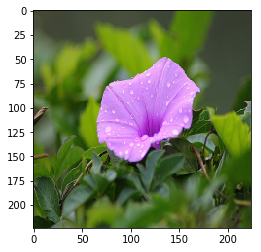

Showing 488 index image, It is 1.0


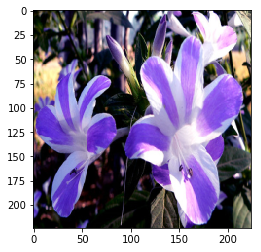

In [21]:
# Randomly show 10 examples of the images

data = tsDatOrg
label = tsLblOrg

for i in range(20):
    index = random.randint(0, len(data)-1)
    print("Showing %s index image, It is %s" %(index, label[index]))
    imgplot = plt.imshow(data[index])
    plt.show()

In [0]:
# Convert the data into 'float32'
# Rescale the values from 0~255 to 0~1
trDat       = trDatOrg.astype('float32')/255
tsDat       = tsDatOrg.astype('float32')/255

# Retrieve the row size of each image
# Retrieve the column size of each image
imgrows     = trDat.shape[1]
imgclms     = trDat.shape[2]
channel     = 3

# # reshape the data to be [samples][width][height][channel]
# # This is required by Keras framework
# trDat       = trDat.reshape(trDat.shape[0], imgrows, imgclms, channel)
# tsDat       = tsDat.reshape(tsDat.shape[0], imgrows, imgclms, channel)

# Perform one hot encoding on the labels
# Retrieve the number of classes in this problem
trLbl       = to_categorical(trLblOrg)
tsLbl       = to_categorical(tsLblOrg)
num_classes = tsLbl.shape[1]

# Define Model

In [37]:
# fix random seed for reproducibility
seed = 29
np.random.seed(seed)

modelname = 'FlowerPower_VGG16'

def createVGG16Model():
    inputs = Input(shape=(imgrows, imgclms, channel))
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dense(4096, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=[inputs],outputs=x)
    
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

def createBaselineModel():
    inputs = Input(shape=(imgrows, imgclms, channel))
    x = Conv2D(30, (4, 4), activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(50, (4, 4), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    x = Dense(32, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=[inputs],outputs=x)
    
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam',
                  metrics=['accuracy'])
    return model
  
model = createVGG16Model()
modelGo = createVGG16Model()

# model = createBaselineModel()
# modelGo = createBaselineModel()
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 56, 56, 128)       0   

In [0]:
filepath        = modelname + ".hdf5"
checkpoint      = ModelCheckpoint(filepath, 
#                                  monitor='val_acc', 
                                  monitor='val_loss',
                                  verbose=0, 
                                  save_best_only=True, 
#                                  mode='max')
                                  mode='min')

                            # Log the epoch detail into csv
csv_logger      = CSVLogger(modelname +'.csv')
#callbacks_list  = [checkpoint, csv_logger, LRScheduler]
callbacks_list  = [checkpoint, csv_logger]

In [39]:
# Fit the model
# This is where the training starts
model.fit(trDat, 
          trLbl, 
          validation_data=(tsDat, tsLbl), 
#          epochs=120, 
          epochs=20, 
          batch_size=16,
          callbacks=callbacks_list)

Train on 3835 samples, validate on 959 samples
Epoch 1/20
3835/3835 [==============================] - 77s 20ms/sample - loss: 0.6968 - acc: 0.5588 - val_loss: 0.6858 - val_acc: 0.5610
Epoch 2/20
3835/3835 [==============================] - 65s 17ms/sample - loss: 0.6870 - acc: 0.5609 - val_loss: 0.6861 - val_acc: 0.5610
Epoch 3/20
3835/3835 [==============================] - 76s 20ms/sample - loss: 0.6870 - acc: 0.5609 - val_loss: 0.6857 - val_acc: 0.5610
Epoch 4/20
3835/3835 [==============================] - 65s 17ms/sample - loss: 0.6867 - acc: 0.5609 - val_loss: 0.6859 - val_acc: 0.5610
Epoch 5/20
3835/3835 [==============================] - 64s 17ms/sample - loss: 0.6864 - acc: 0.5609 - val_loss: 0.6858 - val_acc: 0.5610
Epoch 6/20
3835/3835 [==============================] - 65s 17ms/sample - loss: 0.6862 - acc: 0.5609 - val_loss: 0.6859 - val_acc: 0.5610
Epoch 7/20
3835/3835 [==============================] - 64s 17ms/sample - loss: 0.6864 - acc: 0.5609 - val_loss: 0.6858 - val

In [0]:
## Now the training is complete, we get
# another object to load the weights
# compile it, so that we can do 
# final evaluation on it
modelGo.load_weights(filepath)
modelGo.compile(loss='categorical_crossentropy', 
                optimizer='adam', 
                metrics=['accuracy'])

In [41]:
# Make classification on the test dataset
predicts    = modelGo.predict(tsDat)

# Prepare the classification output
# for the classification report
predout     = np.argmax(predicts,axis=1)
testout     = np.argmax(tsLbl,axis=1)
labelname   = ['flower', 'non-flower']
                                            # the labels for the classfication report


testScores  = metrics.accuracy_score(testout,predout)
confusion   = metrics.confusion_matrix(testout,predout)


print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,predout,target_names=labelname,digits=4))
print(confusion)

Best accuracy (on testing dataset): 56.10%
              precision    recall  f1-score   support

      flower     0.0000    0.0000    0.0000       421
  non-flower     0.5610    1.0000    0.7188       538

    accuracy                         0.5610       959
   macro avg     0.2805    0.5000    0.3594       959
weighted avg     0.3147    0.5610    0.4032       959

[[  0 421]
 [  0 538]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


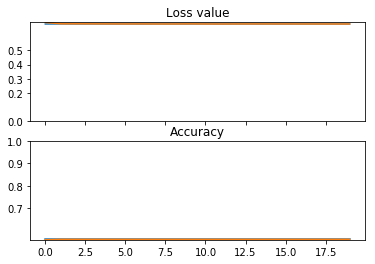

In [42]:
import pandas as pd

records     = pd.read_csv(modelname +'.csv')
plt.figure()
plt.subplot(211)
plt.plot(records['val_loss'])
plt.plot(records['loss'])
plt.yticks([0, 0.20, 0.30, 0.4, 0.5])
plt.title('Loss value',fontsize=12)

ax          = plt.gca()
ax.set_xticklabels([])



plt.subplot(212)
plt.plot(records['val_acc'])
plt.plot(records['acc'])
plt.yticks([0.7, 0.8, 0.9, 1.0])
plt.title('Accuracy',fontsize=12)
plt.show()

In [0]:
wrong_ans_index = []

for i in range(len(predout)):
    if predout[i] != testout[i]:
        wrong_ans_index.append(i)

In [0]:
wrong_ans_index = list(set(wrong_ans_index))

Showing 951 index image
Predicted as 1 but is actually 0


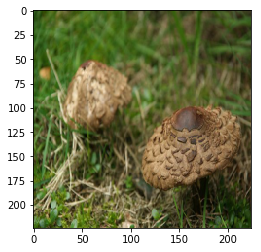

Showing 750 index image
Predicted as 1 but is actually 0


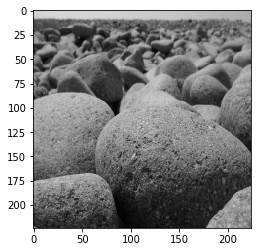

Showing 641 index image
Predicted as 1 but is actually 0


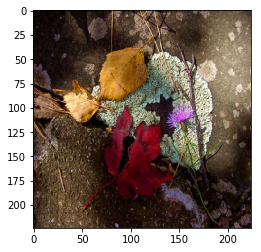

Showing 792 index image
Predicted as 1 but is actually 0


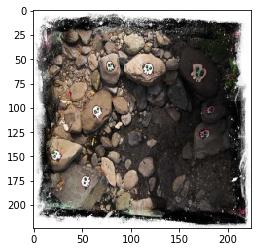

Showing 610 index image
Predicted as 1 but is actually 0


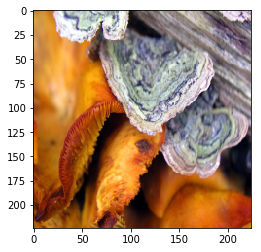

Showing 603 index image
Predicted as 1 but is actually 0


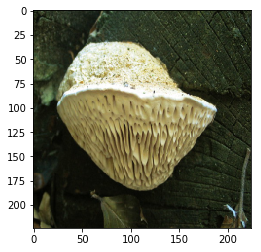

Showing 834 index image
Predicted as 1 but is actually 0


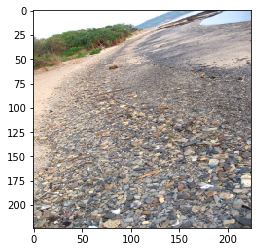

Showing 659 index image
Predicted as 1 but is actually 0


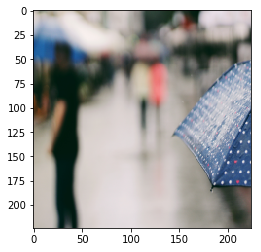

Showing 733 index image
Predicted as 1 but is actually 0


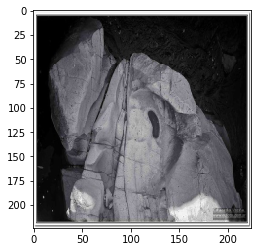

Showing 896 index image
Predicted as 1 but is actually 0


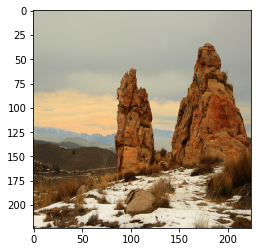

In [48]:
# Randomly show X examples of that was wrong

dataset = tsDatOrg #flowers #fungus #rocks

for index in range(10):
    index = wrong_ans_index[random.randint(0, len(wrong_ans_index)-1)]
    print("Showing %s index image" %(index))
    print("Predicted as %s but is actually %s" %(predout[index], testout[index]))
    imgplot = plt.imshow(data[index])
    plt.show()